# Cnvolutional neural network Image: Tutorial
- 실습조교: 배진수(wlstn215@korea.ac.kr), 김정인(jungin_kim23@korea.ac.kr), 정진용(jy_jeong@korea.ac.kr)

## Colab gpu 연결

#### 런타임 -> 런타임유형 변경 -> 하드웨어 가속기 -> GPU

In [1]:
import torch
torch.cuda.is_available()

False

## 0.모듈 불러오기

In [2]:
''' 기본 모듈 및 시각화 모듈'''
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

'''CNN을 위한 딥러닝 모듈'''
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

''' 결과 평가용 모듈 '''
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

### <GPU 확인, 사용할 device 설정>

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

### <Seed/Random state 고정, 재현성을 위해>

In [5]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)

## 1. 데이터 불러오기: Dogs Vs. Cats

#### https://www.kaggle.com/c/dogs-vs-cats

- 이미지 데이터는 픽셀로 이루어져 있으며, 각 픽셀의 밝기(intensity, 0~255)를 통해 이미지를 나타낼 수 있다.
- Dogs Vs. Cats 데이터는 이런 픽셀 값들을 설명변수(X)로 하여 강이지 or 고양이(Y)에 해당하는 이미지인지 분류하는 문제

### - 데이터 구조  
- 데이터: 강아지 혹은 고양이의 이미지 데이터로 해당 이미지들의 크기는 서로 상이
- 학습 데이터의 개수 : 강아지 이미지 100개 & 고양이 이미지 100개
- 검증 데이터의 개수 : 강아지 이미지 50개 & 고양이 이미지 50개
- 테스트 데이터의 개수 : 강아지 이미지 20개 & 고양이 이미지 20개

<img src="./image/image1.PNG" width="600">

### - 이미지 데이터 전처리  

In [6]:
# transforms.Compose 내에 활용할 이미지 데이터들을 변형할 순서에 맞추어서 순차적으로 리스트 형태로 작성
data_transforms = {
    'train':transforms.Compose([
        transforms.RandomResizedCrop(224), # 출력하는 사이즈에 맞게 crop
        transforms.RandomHorizontalFlip(), # 해당 이미지를 좌우반전 진행
        transforms.ToTensor(), #
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        # RGB채널에 대해서 각각 평균과 표준편차를 활용하여 정규화
    ]),
    'val':transforms.Compose([
        transforms.Resize(300), # 크기가 다른 이미지들을 해당 크기로 조정
        transforms.CenterCrop(224), # 해당 이미지에서 가운데 부분을 특정 크기로 crop
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        # RGB채널에 대해서 각각 평균과 표준편차를 활용하여 정규화
    ]),
    'test':transforms.Compose([
        transforms.Resize(300), # 크기가 다른 이미지들을 해당 크기로 조정
        transforms.CenterCrop(224), # 해당 이미지에서 가운데 부분을 특정 크기로 crop
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        # RGB채널에 대해서 각각 평균과 표준편차를 활용하여 정규화
    ])
}

### - 각각의 이미지들이 해당하는 레이블 폴더에 존재하는 계층적인 폴더 구조
### - Dataset and DataLoader
- __Tensor__ : 데이터를 담고있는 다차원 행렬
- __Dataset__ : 데이터를 불러오고 전처리 하는 과정
- __Data Loader__ : Dataset을 입력받아 배치 사이즈에 맞추어 출력

In [7]:
data_dir = './data/dog_cat'
train_dataset = datasets.ImageFolder(os.path.join(data_dir,'train'),data_transforms['train']) # (데이터의 경로, 전처리 방법)
val_dataset = datasets.ImageFolder(os.path.join(data_dir,'val'),data_transforms['val']) 
test_dataset = datasets.ImageFolder(os.path.join(data_dir,'test'),data_transforms['test'])

In [8]:
# 개인용 PC 윈도우에서는 num_workers=0만 가능함, 그 외 1 이상의 값
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = 4, shuffle = True, num_workers=0)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size = 4 ,shuffle = True ,num_workers = 0)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = 4 , num_workers = 0)

class_names = train_dataset.classes
print("Class names : ",class_names)

Class names :  ['cat', 'dog']


### - 데이터 시각화

In [9]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    # 이미지 시각화를 위해서 tensor가 아닌 numpy로 변환하여 활용
    inp = inp.numpy().transpose((1, 2, 0)) # channel, height, width -> height, width, channel
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean 
    inp = np.clip(inp, 0, 1) # 범위를 설정하여 해당 범위를 넘어가는 값들은 최대 or 최소값으로 대체
    
    plt.figure(figsize=(15,15))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

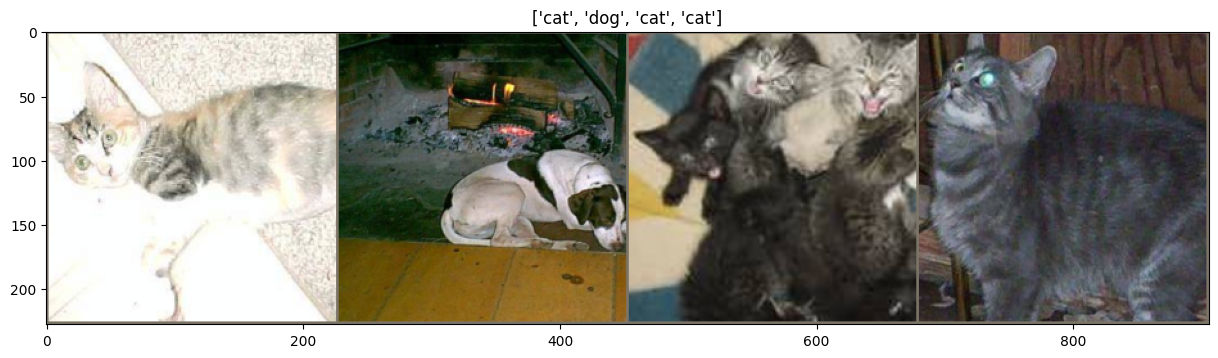

In [10]:
inputs,classes = next(iter(train_dataloader))
out = torchvision.utils.make_grid(inputs) # batch에 해당하는 4장의 이미지들을 그리드 형태로 변환
imshow(out,title=[class_names[x] for x in classes])

## 2. Pre-trained 모델 불러오기 (alexnet)

### Convolution Neural Networks 모델링 방법

<img src="image/image2.PNG" width="600">

<img src="image/image3.PNG" width="600">

#### __Conv2d__ : (in_channels,out_channels,kernel_size,stride,padding)
- in_channels : Convolution 연산을 위해 들어오는 입력 채널 개수
- out_channels : Convolution 연산 이후 만들어지는 채널의 개수
- kernel_size : Filter의 크기를 의미 ( 가로 X 세로 ) or 가로=세로 인경우는 정수값 하나로 표현
- stride : Filter가 건너뛰는 픽셀의 수
- padding : zero-padding을 진행할 사이즈

#### Input_size = (N,C_in,H,W) > Output_size = (N,C_out,OH,OW)
- N : batch_size
- C : 채널의 개수
- H : height
- W : width


In [11]:
model = models.alexnet(pretrained=True)
model

C:\Users\wlstn\miniconda3\envs\LG\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\wlstn\miniconda3\envs\LG\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

### Fine-tuning : 마지막 layer

 - 마지막 linear layer를 통해서 강아지 & 고양이 분류가 가능하도록 2개의 output이 나오도록 변경
 - 기존의 학습된 weight들은 유지하며 마지막 linear layer의 가중치를 학습

In [12]:
num_in = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(num_in,2)

In [13]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [14]:
class Alexnet(torch.nn.Module):
    def __init__(self,num_classes=2): 
        super().__init__()
        
        ''' 모델에 필요한 layer 정의 ''' 
        
        self.convnet = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d(output_size = (6,6))
        
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )
        
    def forward(self, x):
        
        ''' x를 입력받아 진행할 순서 설정 '''
        
        x = self.convnet(x)
        x = self.avgpool(x)
        x = torch.flatten(x,1)
        x = self.classifier(x)

        return x

In [15]:
model_1 = Alexnet()
model_1

Alexnet(
  (convnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
  

## 3. 모델 학습

### - 비용함수

In [16]:
# 비용함수 정의 (분류문제 -> crossentropy 사용)
criterion = nn.CrossEntropyLoss()

### - Optimizer
- __params__ : update를 진행할 모델의 파라미터
- __lr__ : learning rate

In [17]:
optimizer = torch.optim.Adam(model.classifier[-1].parameters(), lr=1e-4)

In [18]:
# 모델을 'gpu' or 'cpu'로 이동
model = model.to(device)

num_epochs = 10

print("Start Training !")
print('-'*50)
print()

train_loss_total = []
val_loss_total = []
best_loss = np.inf

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    print('-' * 10)
    
    train_loss = 0
    val_loss = 0
    train_corrects = 0
    val_corrects = 0
    
    
    '''Train'''
    # 모델을 학습모드로 전환
    model.train()
    for inputs,labels in train_dataloader:
        # 데이터를 'gpu' or 'cpu' 로 이동
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        
        # 모델의 모든 기울기 값을 0으로 설정
        optimizer.zero_grad()
        
        # 데이터를 모델에 입력하여 출력값 계산
        outputs = model(inputs)
        
        #outputs값 중에서 큰 class값을 가져옴
        _,preds = torch.max(outputs,1)
        
        # 비용함수를 활용하여 오차 계산
        loss = criterion(outputs,labels)
        
        # 계산된 오차를 기반으로 기울기 계산
        loss.backward()
        
        # 계산된 기울기를 바탕으로 모델의 파라미터 업데이트
        optimizer.step()
        
        train_loss += loss.item()
        train_corrects += torch.sum(preds == labels.data)
    
    '''Validation'''
    # 모델을 평가모드로 전환
    model.eval()
    # 모델을 평가할때는 기울기 계산 불필요
    with torch.no_grad():
        for inputs,labels in val_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _,preds = torch.max(outputs,1)
            
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == labels.data)
    
    # epoch의 loss 계산
    train_loss_epoch = train_loss/len(train_dataloader)
    val_loss_epoch = val_loss/len(val_dataloader)
    
    #epoch의 accuracy 계산
    train_acc_epoch = train_corrects / len(train_dataset)
    val_acc_epoch = val_corrects / len(val_dataset)

    print(f'{epoch+1} epoch | Train loss: {train_loss_epoch:.3f}, Valid loss: {val_loss_epoch:.3f}')
    print(f'{epoch+1} epoch | Train acc: {train_acc_epoch:.3f}, Valid acc: {val_acc_epoch:.3f}')
    print()

    # validation loss 기준으로 best epoch 계산 (Early stopping)
    if val_loss_epoch < best_loss:
        # best loss 업데이트
        best_loss = val_loss_epoch
        # 최적의 epoch 수와 모델 저장하기
        best_epoch = epoch
        torch.save(model.state_dict(), './best_model_alexnet_image.pt')
    
    train_loss_total.append(train_loss_epoch)
    val_loss_total.append(val_loss_epoch)

print()
print('-'*50)
print(f'Finished Training ! Best Epoch is epoch {best_epoch+1}')

Start Training !
--------------------------------------------------

Epoch 1/10
----------
1 epoch | Train loss: 0.615, Valid loss: 0.374
1 epoch | Train acc: 0.685, Valid acc: 0.880

Epoch 2/10
----------
2 epoch | Train loss: 0.349, Valid loss: 0.244
2 epoch | Train acc: 0.880, Valid acc: 0.930

Epoch 3/10
----------
3 epoch | Train loss: 0.300, Valid loss: 0.199
3 epoch | Train acc: 0.885, Valid acc: 0.940

Epoch 4/10
----------
4 epoch | Train loss: 0.229, Valid loss: 0.163
4 epoch | Train acc: 0.900, Valid acc: 0.960

Epoch 5/10
----------
5 epoch | Train loss: 0.191, Valid loss: 0.140
5 epoch | Train acc: 0.935, Valid acc: 0.960

Epoch 6/10
----------
6 epoch | Train loss: 0.177, Valid loss: 0.124
6 epoch | Train acc: 0.940, Valid acc: 0.970

Epoch 7/10
----------
7 epoch | Train loss: 0.185, Valid loss: 0.116
7 epoch | Train acc: 0.945, Valid acc: 0.970

Epoch 8/10
----------
8 epoch | Train loss: 0.162, Valid loss: 0.111
8 epoch | Train acc: 0.955, Valid acc: 0.970

Epoch 9/10


## 4. 모델 성능 평가

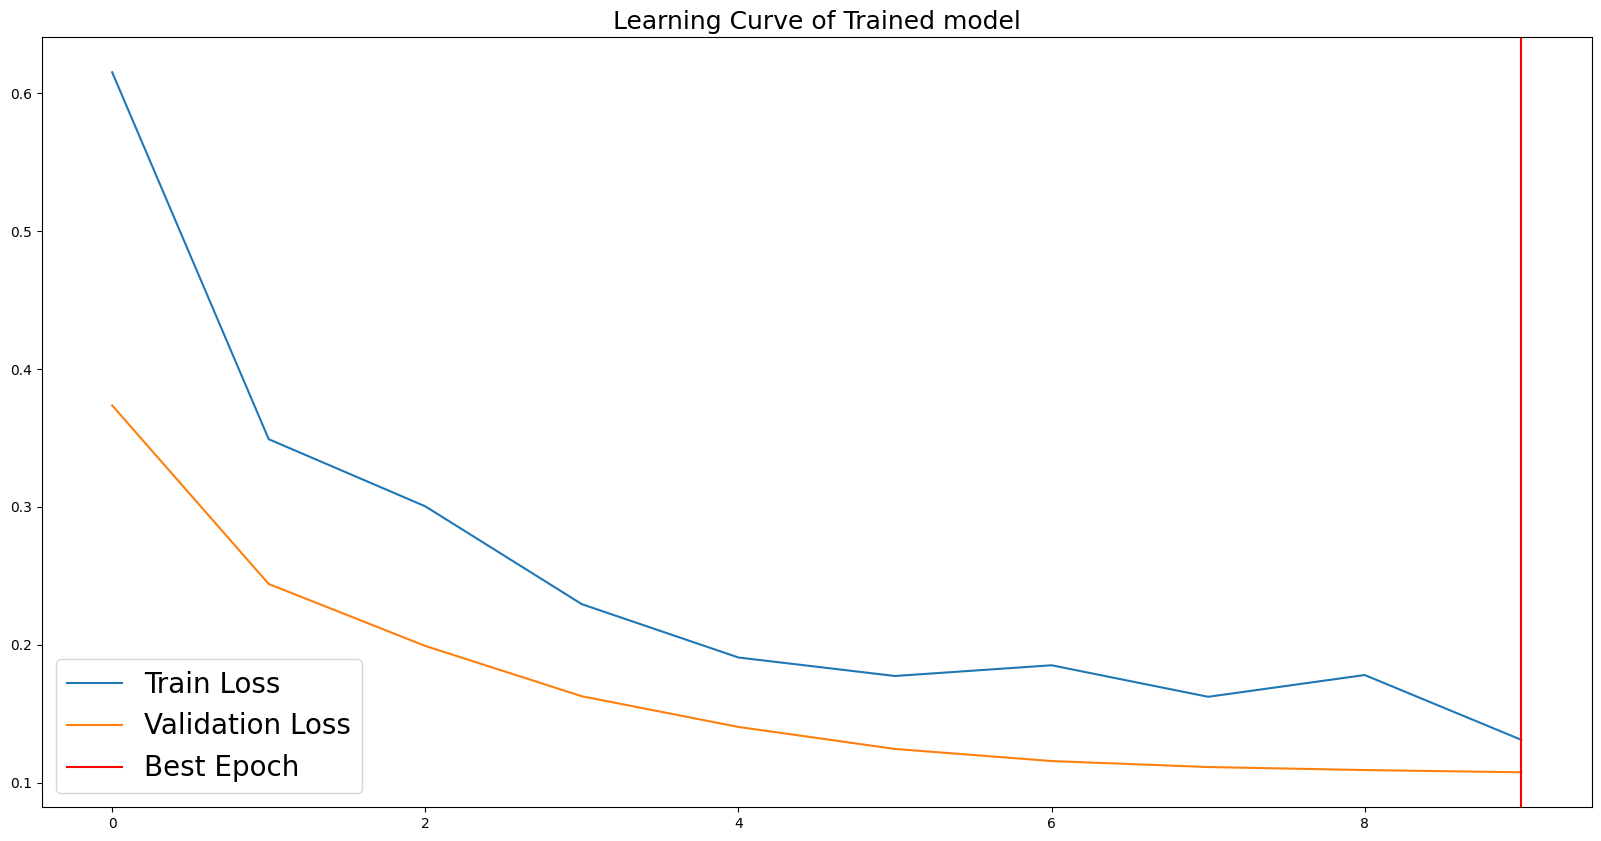

In [19]:
plt.figure(figsize=(20,10))

# 학습 및 검증 로스 변동 관찰하기
plt.plot(train_loss_total,label='Train Loss')
plt.plot(val_loss_total, label='Validation Loss')
# 최적의 모델이 저장된 곳 표시
plt.axvline(x = best_epoch, color='red', label='Best Epoch')
plt.legend(fontsize=20)
plt.title("Learning Curve of Trained model", fontsize=18)
plt.show()

In [20]:
# 최적의 모델 불러오기
ckpt = torch.load('./best_model_alexnet_image.pt')
# 모델 파라미터 불러오기
model.load_state_dict(ckpt)

<All keys matched successfully>

In [21]:
# model을 evaluation 모드로 변경
pred_list = []
true_list = []

model.eval()
model.to(device)

with torch.no_grad():
    for inputs,labels in test_dataloader:
        # 모델의 출력값 계산
        y_logit = model(inputs.to(device))
        # 출력값을 최대로하는 인덱스(class) 저장
        y_pred = torch.argmax(y_logit, dim=1)
        # 예측값과 실제값 저장
        pred_list.extend(y_pred.detach().numpy())
        true_list.extend(labels.detach().numpy())

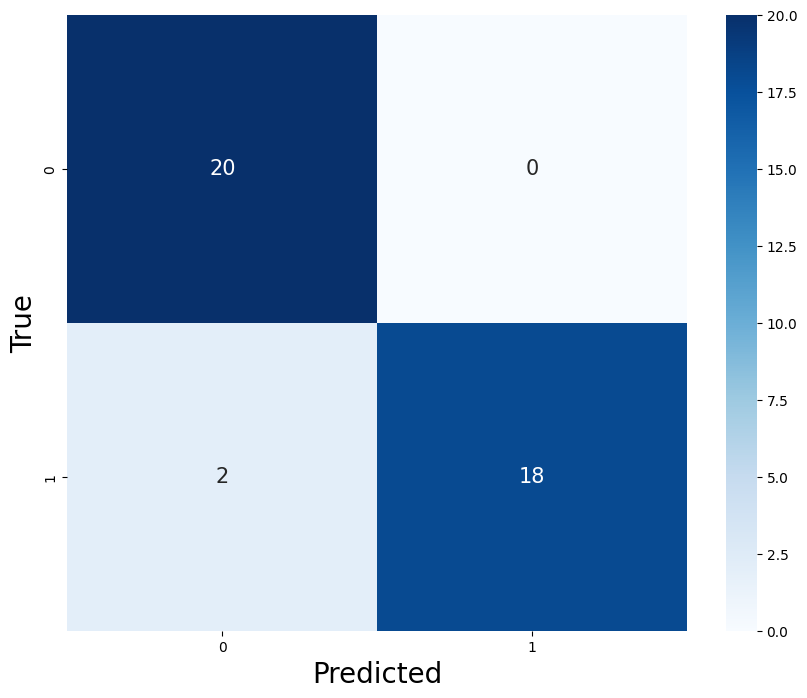

Test Accuracy   : 0.950
Test Sensitivity: 0.950
Test Precision  : 0.955
Test F1 Score   : 0.950


In [22]:
# confusion matrix 계산
cm_train = confusion_matrix(y_true=true_list, y_pred=pred_list)

# confusion matrix 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(data=cm_train, annot=True, fmt='d', annot_kws={'size': 15}, cmap='Blues')
plt.xlabel('Predicted', size=20)
plt.ylabel('True', size=20)
plt.show()

# 평가지표 계산
test_acc = accuracy_score(true_list, pred_list)
test_rec = recall_score(true_list, pred_list, average='macro')
test_prec = precision_score(true_list, pred_list, average='macro')
test_f1 = f1_score(true_list, pred_list, average='macro')

print('Test Accuracy   : {:.3f}'.format(test_acc))
print('Test Sensitivity: {:.3f}'.format(test_rec))
print('Test Precision  : {:.3f}'.format(test_prec))
print('Test F1 Score   : {:.3f}'.format(test_f1))

## EOD